### Load the data from Excel

In [1]:
import pandas as pd
import numpy as np
import cmdstanpy as c
import seaborn as sns
import matplotlib.pyplot as plt
print(c.__version__)

1.0.0


In [2]:

f = pd.ExcelFile( "Cumulus Expansion dataset.xlsx")                                                  
print(f.sheet_names)
dfs = {}
for sheet_name in f.sheet_names:
    dfs[sheet_name] = pd.read_excel(f, sheet_name, skiprows=[0,1], header=None,usecols=[1,2,3,4,5,6])

['Area method', '3distance method', 'Score method']


In [3]:
dfs['Area method']


,1,2,3,4,5,6
0,12.147664,30.392196,8.360958,7.569974,4.754687,2.491603
1,178.072184,190.503002,178.518719,170.957529,194.124455,180.524075
2,110.545249,109.025768,112.780247,108.246239,117.683475,99.680823
3,61.779680,63.414298,76.387161,70.105727,69.782141,75.691881
4,35.756752,74.652821,64.172850,47.696356,58.703652,65.581084
...,...,...,...,...,...,...
255,141.696152,142.336361,233.908814,121.368418,144.086331,260.232729
256,53.737893,47.563056,58.645541,34.494464,42.131194,62.355879
257,81.012607,72.006168,76.574489,73.516026,67.435111,81.598661
258,132.129189,139.583314,124.941917,126.100468,145.678629,155.866156


In [4]:
def get_matrix(xls_df, judges=3, repeats=2):
    objects = len(xls_df.index)
    x = np.zeros((objects, judges, repeats))
    x[:,0,0]=xls_df[1]
    x[:,0,1]=xls_df[4]
    x[:,1,0]=xls_df[2]
    x[:,1,1]=xls_df[5]
    x[:,2,0]=xls_df[3]
    x[:,2,1]=xls_df[6]
    return x

## Area method analysis

In [5]:
x = get_matrix(dfs['Area method'])

### Let's take a look at the data

In [6]:
def describe_data(x):
    x_min = np.min(x)
    x_max = np.max(x)
    print("Observations are in the range :[", x_min,"-", x_max,"]")
    x_mean = np.mean(x)
    x_median = np.median(x)
    print("And their mean is ", x_mean, " and their median is ", x_median)
    x_var = np.var(x)
    print("The variance of x is ", x_var, " and its square root is ", np.std(x))
    return {"l_mu":x_min, "u_mu":x_max}

In [7]:
describe_data(x)

Observations are in the range :[ -23.69166980084944 - 177110.81520634276 ]
And their mean is  192.2298955499387  and their median is  70.54530135215217
The variance of x is  20079883.996463265  and its square root is  4481.058356734853


{'l_mu': -23.69166980084944, 'u_mu': 177110.81520634276}

### The maximum is too large. It corresponds with the first measurement of observer3 of oocyte 22.16. I remove the oocyte
<!---### I substitute it by the second measurement --->

In [8]:
max_index =  np.argmax(x)
i_max = max_index//6
print(i_max)
x = np.delete(x,i_max,axis=0)
print(x.shape)
#j_max = (max_index%6)//2
#print(j_max)
#k_max = (max_index%6)%2
#x[i_max,j_max, k_max]  = x[i_max,j_max, (k_max+1 )%2] 


148
(259, 3, 2)


In [9]:
describe_data(x)

Observations are in the range :[ -23.69166980084944 - 346.268195683231 ]
And their mean is  78.76804994478088  and their median is  70.39216868511728
The variance of x is  2802.9555372004834  and its square root is  52.94294605705734


{'l_mu': -23.69166980084944, 'u_mu': 346.268195683231}

<AxesSubplot:ylabel='Density'>

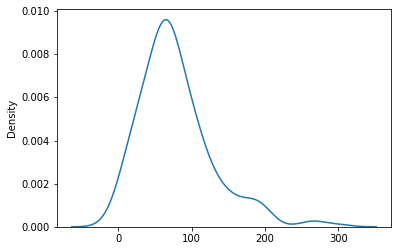

In [10]:
sns.kdeplot(np.mean(x, axis=(1,2)))

In [11]:
x_sigma_T = np.std(np.mean(x, axis=(1,2)))
icc_approx = (x_sigma_T*x_sigma_T) / np.var(x)
print("First ICC approximation:", icc_approx)

First ICC approximation: 0.922668490535267


In [12]:
data = {
    "N": x.shape[0],
    "J": x.shape[1],
    "R": x.shape[2],
    "x": x,
    "l_mu": np.min(x),
    "u_mu": np.max(x),
    "l_sigma_T": 0.0,
    "u_sigma_T": np.std(x)*1.1,
    "l_sigma_J": 0.0,
    "u_sigma_J": np.std(x)*1.1,
    "l_sigma_I": 0.0,
    "u_sigma_I": np.std(x)*1.1
}

def bayesian_analysis(data):
    m = c.CmdStanModel(stan_file="annelies.stan")
    posterior = m.sample(data=data, iter_sampling=200, adapt_delta=0.999)
    return m, posterior

def describe_ba(posterior):
    print(posterior.diagnose())
    l_mu = posterior.stan_variable("mu")
    sns.kdeplot(l_mu)
    plt.title("Density plot for mu")
    plt.show()
    print("The median of mu is:", np.median(posterior.stan_variable("mu")))
    l_sigma_T=posterior.stan_variable("sigma_T")
    #print(l_sigma_T)
    sns.kdeplot(l_sigma_T)
    plt.title("Density plot for sigma_T")
    plt.show()
    print("The median of sigma_T is ",np.median(l_sigma_T))
    l_sigma_J=posterior.stan_variable("sigma_J")
    sns.kdeplot(l_sigma_J)
    plt.title("Density plot for sigma_J")
    plt.show()
    print("The median of sigma_J is ",np.median(l_sigma_J))
    l_sigma_I=posterior.stan_variable("sigma_I")
    for i in range(3):
        sns.kdeplot(l_sigma_I[:,i], label="obs_"+str(i+1))
    plt.legend()
    plt.title("Density plot for the sigma_I of each of the observers")
    plt.show()
    for i in range(3):
        print("The median of sigma_I for observer ", i+1," is ", np.median(l_sigma_I[:,i]))
    l_a = posterior.stan_variable("a")
    for i in range(3):
        sns.kdeplot(l_a[:,i], label="obs_"+str(i+1))
    plt.legend()
    plt.title("Density plot of the bias estimate of each observer")
    plt.show()
    l_a_medians = np.median(l_a, axis=0)
    for i in range(3):
        print("The median of the bias for observer ", i+1," is ", l_a_medians[i])
    l_b = posterior.stan_variable("b")
    for i in range(5):
        sns.kdeplot(l_b[:,i]+l_mu, label="oocyte_"+str(i+1))
    plt.legend()
    plt.title("Density plot of the real growth of the first 5 oocytes")
    plt.show()

def bayesian_icc(posterior):
    l_sigma_I=posterior.stan_variable("sigma_I")
    l_sigma_T=posterior.stan_variable("sigma_T")
    l_sigma_J=posterior.stan_variable("sigma_J")
    l_sigma_E=np.sqrt(np.mean(l_sigma_I*l_sigma_I,axis=1))
    rho=(l_sigma_T*l_sigma_T)/(l_sigma_T*l_sigma_T + l_sigma_J*l_sigma_J + l_sigma_E*l_sigma_E)
    return rho

def show_icc(rho):
    sns.kdeplot(rho)
    plt.title("Density plot of the ICC")
    plt.show()
    print("The median ICC value is ", np.median(rho))
    print("The mean ICC value is ", np.mean(rho))
    #sns.kdeplot(l_sigma_E)

In [13]:
m_area, posterior_area = bayesian_analysis(data)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Processing csv files: /tmp/tmp018zlloy/annelies-20220128000630_1.csv, /tmp/tmp018zlloy/annelies-20220128000630_2.csv, /tmp/tmp018zlloy/annelies-20220128000630_3.csv, /tmp/tmp018zlloy/annelies-20220128000630_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  mu, a[1], a[2], a[3]
Such high values indicate incomplete mixing and biased estimation.
You should consider regularizating your model with additional prior information or a more effective parameterization.

Processing complete.



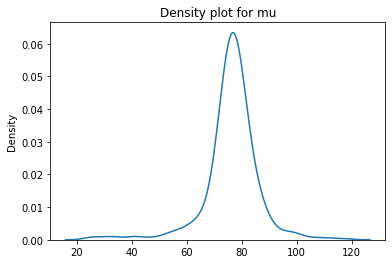

The median of mu is: 76.71885


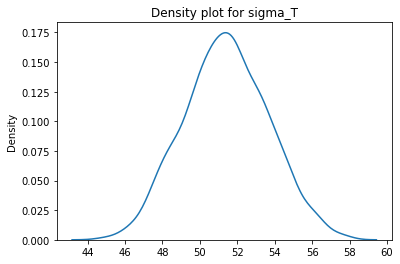

The median of sigma_T is  51.40975


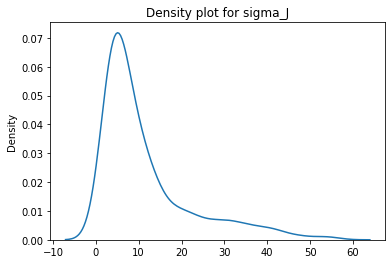

The median of sigma_J is  7.113894999999999


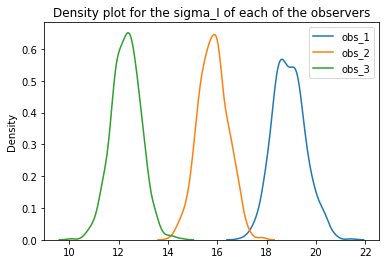

The median of sigma_I for observer  1  is  18.885599999999997
The median of sigma_I for observer  2  is  15.8093
The median of sigma_I for observer  3  is  12.311


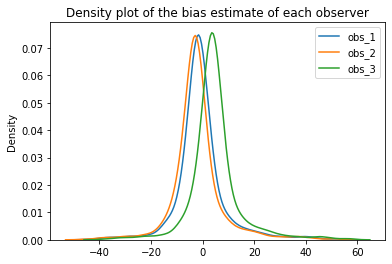

The median of the bias for observer  1  is  -1.4687000000000001
The median of the bias for observer  2  is  -2.755415
The median of the bias for observer  3  is  3.99549


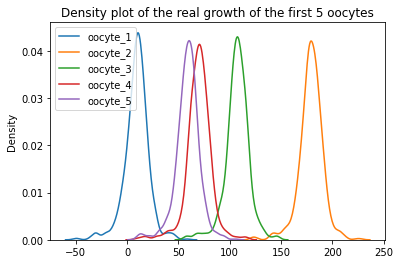

In [14]:
describe_ba(posterior_area)

### Now, we compute the ICC

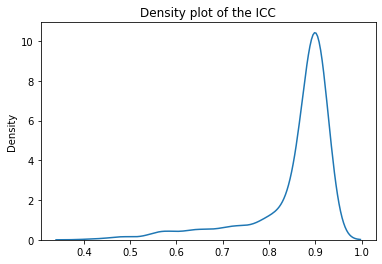

The median ICC value is  0.8937263579477255
The mean ICC value is  0.8539010866323862


In [15]:
rho_area = bayesian_icc(posterior_area)
show_icc(rho_area)

### A more traditional way, by fitting the very same model using maximum likelihood and assessing the ICC from the ML parameters 

In [39]:
def ICC(sigma_T, sigma_J, sigma_I):
    sT2= sigma_T*sigma_T
    sJ2= sigma_J*sigma_J
    return sT2 / (sT2 + sJ2 + np.mean(sigma_I*sigma_I))

def ml_icc(m, posterior, data):
    inits = {
        "mu": np.median(posterior.stan_variable("mu")),
        "sigma_T": np.median(posterior.stan_variable("sigma_T")),
        "sigma_J": np.median(posterior.stan_variable("sigma_J")),
        "sigma_I": np.median(posterior.stan_variable("sigma_I"), axis=0),
        "a": np.median(posterior.stan_variable("a"), axis=0),
        "b": np.median(posterior.stan_variable("b"), axis=0)
    }
    #print(inits)
    opt = m.optimize(data=data,
                     algorithm="lbfgs",
                     inits=inits,
                     init_alpha=1e-10,
                     #output_dir=".",
                     #show_console=True,
                     tol_rel_grad=1e2,
                     tol_rel_obj=1e2,
                     iter=100000
                     )
    icc_ml = ICC(opt.stan_variable("sigma_T"), opt.stan_variable("sigma_J"), opt.stan_variable("sigma_I"))
    print("The ICC estimated by maximum likelihood is ", icc_ml)
    return opt

In [40]:
opt_area = ml_icc(m_area, posterior_area, data) 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


The ICC estimated by maximum likelihood is  0.9169635118969278


In [18]:
opt_area.stan_variables()

{'mu': 78.7951,
 'sigma_T': 51.6013,
 'sigma_J': 2.82261,
 'sigma_I': array([19.1435, 15.9327,  8.8962]),
 'a': array([-1.2602 , -2.64684,  3.91203]),
 'b': array([-7.14103e+01,  9.98163e+01,  2.72301e+01, -7.87487e+00,
        -1.84854e+01, -4.73424e+01, -9.55386e+01,  2.38895e+01,
        -4.95600e+01, -6.00970e+01, -4.44270e+01,  1.02454e+02,
        -1.55237e+01, -3.21206e+01, -7.41945e+01, -1.35253e+01,
         3.86563e+01, -5.85402e+00, -8.97021e+00, -1.12215e+01,
         1.35562e+01, -1.51060e+00,  3.42187e+01,  4.23103e+01,
         1.22905e+02, -3.82911e+01, -2.87655e+01, -6.96432e+01,
        -2.27533e+01,  6.79588e+01, -1.55908e+00, -3.23805e+01,
         3.02121e+01,  1.63765e+01,  1.21349e+01,  2.14728e+01,
         6.28224e+01, -3.49171e+00, -1.04611e+01, -4.75156e+01,
        -2.18253e+01, -3.51622e+01,  1.61675e+01,  3.68812e+01,
        -4.53376e+01, -4.84668e+01,  1.84576e+01, -1.90021e+01,
        -1.17442e+01, -8.64173e+00, -4.47117e+01, -1.52019e+01,
        -3.9

# 3 distance method analysis

In [19]:
x3d = get_matrix(dfs['3distance method'])

Since there are some errors in the data, we remove those rows

In [20]:
rows_with_errors = np.unique(np.argwhere(np.isnan(x3d))[:,0])
x3d = np.delete(x3d, list(rows_with_errors), axis=0)
print("The rows with problems appear in the excel file with numbers ", rows_with_errors+3)

The rows with problems appear in the excel file with numbers  [107 124 140 163 169 215 227 238 249]


### Let's take a look at the data

In [21]:
describe_data(x3d)

Observations are in the range :[ -35.292399069913145 - 353.9398240535147 ]
And their mean is  53.74766609175614  and their median is  48.4233589820373
The variance of x is  1566.9858487826496  and its square root is  39.58517208226648


{'l_mu': -35.292399069913145, 'u_mu': 353.9398240535147}

<AxesSubplot:ylabel='Density'>

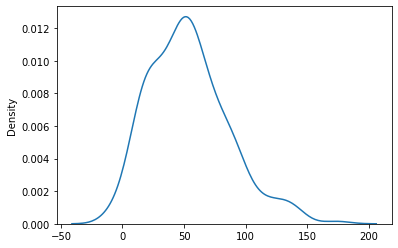

In [22]:
sns.kdeplot(np.mean(x3d, axis=(1,2)))

In [23]:
x_sigma_T = np.std(np.mean(x3d, axis=(1,2)))
icc_approx3d = (x_sigma_T*x_sigma_T) / np.var(x3d)
print("First ICC approximation:", icc_approx3d)

First ICC approximation: 0.6594974632464382


In [24]:
data3d = {
    "N": x3d.shape[0],
    "J": x3d.shape[1],
    "R": x3d.shape[2],
    "x": x3d,
    "l_mu": np.min(x3d),
    "u_mu": np.max(x3d),
    "l_sigma_T": 0.0,
    "u_sigma_T": np.std(x3d)*1.1,
    "l_sigma_J": 0.0,
    "u_sigma_J": np.std(x3d)*1.1,
    "l_sigma_I": 0.0,
    "u_sigma_I": np.std(x3d)*1.1
}


In [25]:
m3d, posterior3d = bayesian_analysis(data3d)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Processing csv files: /tmp/tmp018zlloy/annelies-20220128000709_1.csv, /tmp/tmp018zlloy/annelies-20220128000709_2.csv, /tmp/tmp018zlloy/annelies-20220128000709_3.csv, /tmp/tmp018zlloy/annelies-20220128000709_4.csv

Checking sampler transitions treedepth.
200 of 800 (25%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



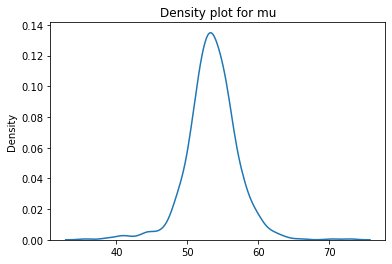

The median of mu is: 53.47755


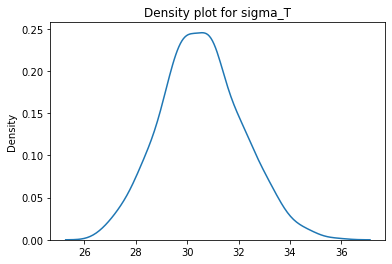

The median of sigma_T is  30.50625


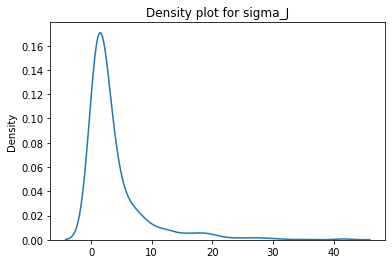

The median of sigma_J is  2.029285


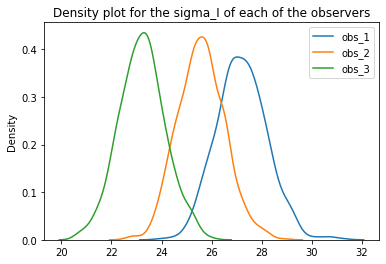

The median of sigma_I for observer  1  is  27.1934
The median of sigma_I for observer  2  is  25.582250000000002
The median of sigma_I for observer  3  is  23.2284


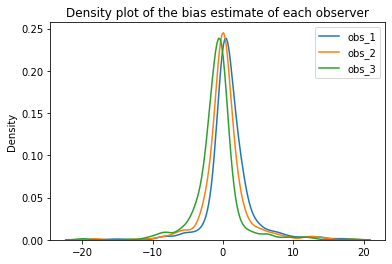

The median of the bias for observer  1  is  0.5770575
The median of the bias for observer  2  is  0.039758
The median of the bias for observer  3  is  -0.670806


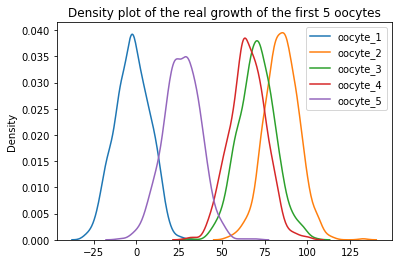

In [26]:
describe_ba(posterior3d)

### Now, we compute the ICC

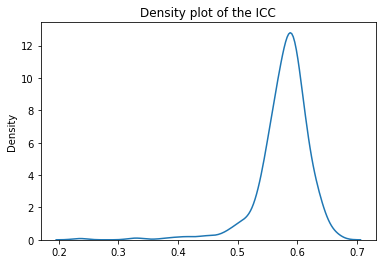

The median ICC value is  0.5844467711171075
The mean ICC value is  0.5774835694518623


In [27]:
rho3d = bayesian_icc(posterior3d)
show_icc(rho3d)

### A more traditional way, by fitting the very same model using maximum likelihood and assessing the ICC from the ML parameters 

In [41]:
opt3d = ml_icc(m3d, posterior3d, data3d) 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


The ICC estimated by maximum likelihood is  0.7463629222236228


In [29]:
opt3d.stan_variables()

{'mu': 53.596,
 'sigma_T': 38.6837,
 'sigma_J': 3.27678e-08,
 'sigma_I': array([22.6166, 24.977 , 19.7544]),
 'a': array([-2.30569e-15, -6.90559e-15, -2.26059e-14]),
 'b': array([-5.58598e+01,  3.14264e+01,  1.69422e+01,  1.12484e+01,
        -2.69689e+01, -2.03202e+01, -3.94613e+01,  1.49131e+01,
        -4.22844e+01, -1.53128e+01,  2.60743e+00,  5.40324e+01,
        -9.68885e+00, -3.13911e+01, -3.83210e+01,  5.42450e-01,
        -1.81234e+01,  7.03143e+00,  2.60292e+00, -1.55193e+01,
         1.00570e+01, -8.25159e+00,  1.45914e+00, -2.71128e+01,
         2.87561e+01, -2.31507e+01, -3.33080e+01, -4.08332e+01,
        -1.85266e+01,  1.97020e+01,  4.36712e+01, -3.48107e+01,
         1.13655e+01,  2.36722e+00,  9.78560e+00, -3.27328e+01,
         1.59273e+01, -5.03804e+00, -3.39116e+00, -2.13905e+01,
        -3.48195e+01, -8.62649e+00,  8.45028e-01,  3.10088e+01,
        -2.64390e+01,  1.97736e+01,  3.20546e+01, -1.33693e+01,
        -3.30135e+01,  2.21634e+00, -4.09798e+00,  2.44363e+0

# Score method analysis

In [30]:
x_s = get_matrix(dfs['Score method'])

In [32]:
describe_data(x_s)

Observations are in the range :[ 0.0 - 4.0 ]
And their mean is  2.337820512820513  and their median is  2.0
The variance of x is  0.9057490959894806  and its square root is  0.951708514194068


{'l_mu': 0.0, 'u_mu': 4.0}

In [38]:
x_sigma_T = np.std(np.mean(x_s, axis=(1,2)))
icc_approx = (x_sigma_T*x_sigma_T) / np.var(x_s)
print("First ICC approximation:", icc_approx)

First ICC approximation: 0.4801724501651596


In [33]:
data_s = {
    "N": x_s.shape[0],
    "J": x_s.shape[1],
    "R": x_s.shape[2],
    "x": x_s,
    "l_mu": np.min(x_s),
    "u_mu": np.max(x_s),
    "l_sigma_T": 0.0,
    "u_sigma_T": np.std(x_s)*1.1,
    "l_sigma_J": 0.0,
    "u_sigma_J": np.std(x_s)*1.1,
    "l_sigma_I": 0.0,
    "u_sigma_I": np.std(x_s)*1.1
}


In [34]:
m_s, posterior_s = bayesian_analysis(data_s)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Processing csv files: /tmp/tmp018zlloy/annelies-20220128000759_1.csv, /tmp/tmp018zlloy/annelies-20220128000759_2.csv, /tmp/tmp018zlloy/annelies-20220128000759_3.csv, /tmp/tmp018zlloy/annelies-20220128000759_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



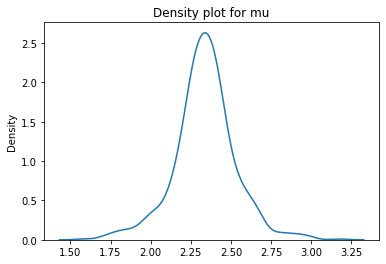

The median of mu is: 2.341265


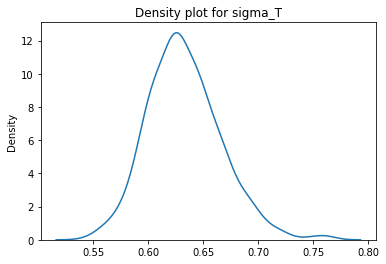

The median of sigma_T is  0.629677


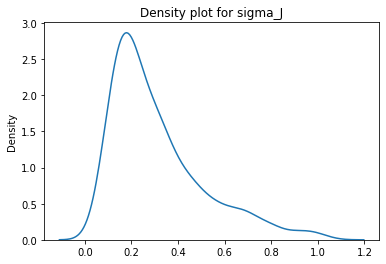

The median of sigma_J is  0.25114400000000003


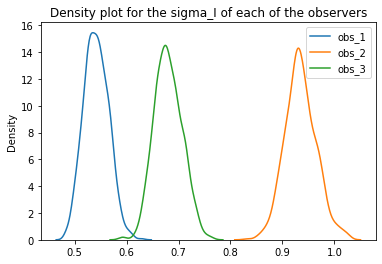

The median of sigma_I for observer  1  is  0.540825
The median of sigma_I for observer  2  is  0.9328875
The median of sigma_I for observer  3  is  0.678314


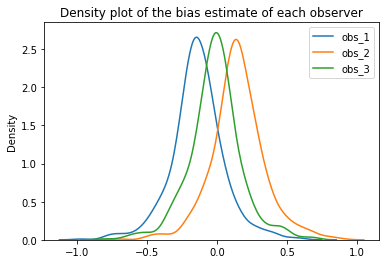

The median of the bias for observer  1  is  -0.14006000000000002
The median of the bias for observer  2  is  0.1438575
The median of the bias for observer  3  is  -0.012040100000000001


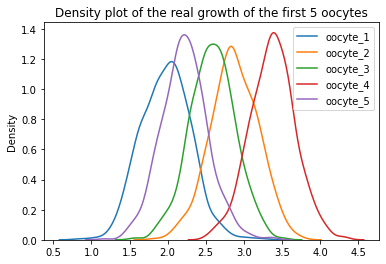

In [35]:
describe_ba(posterior_s)

### Now, we compute the ICC

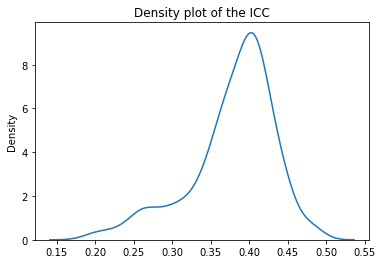

The median ICC value is  0.39087157873774087
The mean ICC value is  0.378349904514677


In [36]:
rho_s = bayesian_icc(posterior_s)
show_icc(rho_s)

### A more traditional way, by fitting the very same model using maximum likelihood and assessing the ICC from the ML parameters 

In [42]:
opt_s = ml_icc(m_s, posterior_s, data_s) 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


The ICC estimated by maximum likelihood is  0.4194120943594027
